In [21]:
%reload_ext autoreload
%matplotlib inline

In [11]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
import datetime as dt


from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings
import pickle

from scipy.interpolate import interp1d
import scipy.interpolate as si
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit


#-- Own settings

from settings import *

## current script object
thismodule = sys.modules[__name__]
workdir = os.getcwd()
# Add own module library to path
moduledir, fcndir = defineDir(workdir)

# load own libraries
from conditionalstats import *
from conditionalstats_chunked import *
import plot1D as p1d
from casestudy import *


# own DYAMOND functions
from fcns_load_DYAMOND_SAM import *
# own TOOCAN functions
from load_TOOCAN_DYAMOND_modif_BF import load_TOOCAN_DYAMOND

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'plot1D', 'plot2D', 'plotCondPDFs', 'lifecycle_mapping']
Own modules available: ['load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_RCEMIP_SAM', 'fcns_multiscale_extremes', 'PrecipGrid', 'fcns_load_DYAMOND_SAM', 'fcns_movie']


In [12]:
figdir = os.path.join(os.path.dirname(workdir),'figures/test_theory')
os.makedirs(figdir,exist_ok=True)

# Load distributions and conditional distributions

1. Distribution de pluie (au cours du temps)
2. Distribution de pluie conditionnée (à TOOCAN, en fonction du temps)
3. Pente des distributions
4. Fréquence d'occurrence des systèmes (en fonction du temps)
5. 

In [10]:
path_dy = '/data/bfildier/DYAMOND_REGIONS/205E_250E_0N_20N/SAM/'
path_dy_2D = os.path.join(path_dy,'2D')

In [13]:
regions = [regionNameFromCoord(box) for box in [box_1,box_2,box_3]]+['tropics']
masks = ['all','TOOCAN','PW_40']
varids = 'pr','PW'
varids_DY = 'Prec','PW'
i_t_0 = 832
i_t_end = 1917

In [14]:
###---- Load precomputed distributions

save_dir = os.path.join(DIR_OUT,'DYAMOND_case_studies')
os.makedirs(save_dir,exist_ok=True)

#- computation
compute_again = False

# load from disk
if not compute_again:

    dict_cs = pickle.load(open(os.path.join(save_dir,'dict_case_studies_all_regions.pickle'),'rb'))

# compute
if compute_again:

    dict_cs = {}

    for region in regions:
        
        print()
        print('**-- %s --**'%region)
        print()

        # init regional case study
        cs = CaseStudy(name='DYAMOND-SAM',
                           region=region,
                           rel_tab_dyam_seg=loadRelTable('DYAMOND_SEG'))

        # geographical parameters
        if region == 'tropics':
            lon_slice = slice(None,None)
            lat_slice = slice(-30,30)
        else:
            reg_coords = regionCoordsFromName(region)
            lon_slice = slice(reg_coords[0]%360,reg_coords[1]%360)
            lat_slice = slice(reg_coords[2],reg_coords[3])

        cs.setSimulationSpecs(i_t_min = 832,
                                      i_t_max = 1917,
                                      lat_slice=lat_slice,
                                      lon_slice=lon_slice)

        # load and compute distributions
        print('Load all time distributions')
        for varid in 'Prec','PW':

            print(varid)

            for mask in 'all','PW_40','TOOCAN','TOOCAN_PW_40':

                if varid == 'PW' and mask == 'TOOCAN_PW_40':
                    continue
                
                print('-',mask)

                # where sliced distributions are stored
                cs.setDirectories(region,varid,mask)

                # load all distributions
                cs.loadDistSliced(varid,mask)

        # compute mean precip time series
        cs.computeMean(varid='Prec',mask='all')

        # compute mean (time series) of PW above 40mm
        cs.computeMean(varid='PW',mask='PW_40')

        # find "missing" time indices
        cs.findTimeIndToIgnore()
        
        # store times
        cs.storeTimes()

        # compute full distributions
        print('compute full distributions')
        for varid in 'Prec','PW':

            print(varid)

            for mask in 'all','PW_40','TOOCAN','TOOCAN_PW_40':

                if varid == 'PW' and mask == 'TOOCAN_PW_40':
                    continue

                print('-',mask)
                cs.combineDistributions(varid,mask)

        # save
        dict_cs[region] = cs

    # save on disk
    pickle.dump(dict_cs,open(os.path.join(save_dir,'dict_case_studies_all_regions.pickle'),'wb'))


In [8]:
save_dir

'../results/DYAMOND_case_studies'

In [9]:
! ls ../results/DYAMOND_case_studies

dict_case_studies_all_regions.pickle


In [9]:
# # Load precomputed distributions

# dict_distribs = {}

# for region in regions:
    
#     # init
#     dict_distribs[region] = {}

#     for varid,varid_DY in zip(varids,varids_DY):

#         # init
#         dict_distribs[region][varid] = {}
        
#         for mask in masks:
            
#             print(region,varid,mask)
            
#             # init
#             dict_distribs[region][varid][mask] = {}
            
#             for i_t in np.arange(i_t_0,i_t_end+1):
                
#                 if i_t%100 == 0 or i_t in [i_t_0,i_t_end]:
#                     print(i_t,end='..')
                
#                 filename = '../results/%s/%s/%s/time_slices/dist_%s_t_%d.pickle'%(region,varid_DY,mask,varid,i_t)

#                 # load if exists
#                 if len(glob.glob(filename)) > 0:
                    
#                     dict_distribs[region][varid][mask][i_t] = pickle.load(open(filename,'rb'))
                
#             print()

In [17]:
# regions of interest
warm_pool = '130E_165E_0N_20N'
eastern_pacific = '205E_250E_0N_20N'
atlantic = '310E_340E_0N_20N'

# Pacific ITCZ

1. Distribution de pluie (au cours du temps)
2. Distribution de pluie conditionnée (à TOOCAN, en fonction du temps)

f_R_e(P99.9) =  0.5518218978941911
slope alpha, all: -15.600796644985476
slope alpha, R: -15.390332027386451
slope beta, all: -22.026334079441092
slope beta, R: -9.956708898519192


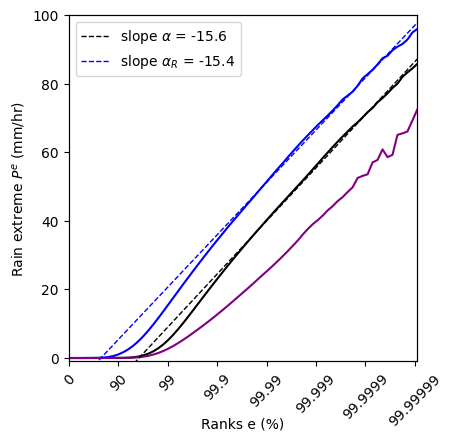

In [22]:
# Show distributions

region = warm_pool
maskid = 'TOOCAN'

# Full
dist_all = dict_cs[region].dist_pr_all
# in Region
# dist_R = dict_cs[region].dist_pr_PW_40
dist_R = getattr(dict_cs[region],'dist_pr_%s'%maskid)

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

ranks = dist_all.ranks
rankmax = 99.99999

#- distributions

#~ P(f^e)
perc_all = dist_all.percentiles
perc_all[perc_all < 0] = 0
f_e = 1-ranks/100

#~ P(f^{e|R})
perc_R = dist_R.percentiles
perc_R[perc_R < 0] = 0

#~ fraction of rain percentile within weather regime expressed as f_R_e*perc_all
# interpolate f^{e|R} onto P
# f_interp = si.interp1d(np.hstack([0,perc_R]),np.hstack([0,ranks]),'spline')
# ranks_e_R = f_interp(perc_all)
# f_e_R = 1-ranks_e_R/100

f_interp = si.interp1d(perc_R,1-ranks/100)
f_e_R = f_interp(perc_all)
# get f_R
time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
f_R = np.mean(np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t]))
# compute ranks(f_R_e)
f_R_e = f_e_R*f_R/f_e
perc_R_e = f_R_e*perc_all
# print value at rank
rank_e = 99.9
i_e = dist_all.indexOfRank(rank_e)
print('f_R_e(P99.9) = ',f_R_e[i_e])

# -- fit of distributions
s_fit = slice(30,70)
x = np.log10(1-ranks/100)
y_all = perc_all
y_R = perc_R

# mask
def func(x,a,b):
    return a * x + b
popt_all, pcov = curve_fit(func,x[s_fit],y_all[s_fit])
popt_R, pcov = curve_fit(func,x[s_fit],y_R[s_fit])
alpha_all,beta_all = popt_all[0],popt_all[1]
alpha_WP,beta_WP = popt_R[0],popt_R[1]
print('slope alpha, all:',popt_all[0])
print('slope alpha, R:',popt_R[0])
print('slope beta, all:',popt_all[1])
print('slope beta, R:',popt_R[1])

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
p1d.showData(ax,ranks,perc_all, c='k',rankmin=0, rankmax = rankmax)
p1d.showData(ax,ranks,perc_R, c='b',rankmin=0, rankmax = rankmax)
p1d.showData(ax,ranks,perc_R_e, c='purple',rankmin=0, rankmax = rankmax)

p1d.showData(ax,ranks,func(x,*popt_all), c='k',linestyle='--',linewidth=1,rankmin=0, rankmax = rankmax,label=r'slope $\alpha$ = %2.1f'%popt_all[0])
p1d.showData(ax,ranks,func(x,*popt_R), c='b',linestyle='--',linewidth=1,rankmin=0, rankmax = rankmax,label=r'slope $\alpha_R$ = %2.1f'%popt_R[0])

# legend
ax.legend()

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel('Rain extreme $P^e$ (mm/hr)')

ax.set_ylim((-1,100))

plt.savefig(os.path.join(figdir,'dist_P_PR_%s.pdf'%region),bbox_inches='tight')

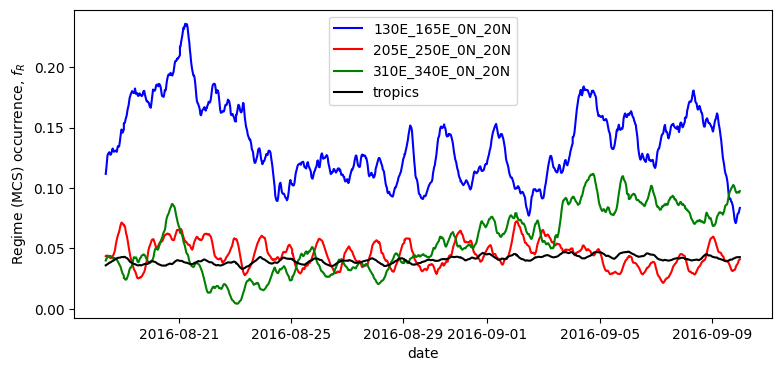

In [23]:
# Time variation of f_R

regions = '130E_165E_0N_20N','205E_250E_0N_20N','310E_340E_0N_20N','tropics'
maskid = 'TOOCAN'
cols = 'blue','red','green','k'
varid = 'Prec'

fig,ax = plt.subplots(figsize=(9,4))
    
for region,col in zip(regions,cols):
    
    # time
    time = dict_cs[region].time

    # fraction
    time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
    frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])

    ax.plot(time,frac_over_time,c=col,label=region)
    
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)

ax.legend()
    
ax.set_xlabel('date')
ax.set_ylabel(r'Regime (MCS) occurrence, $f_R$')

plt.savefig(os.path.join(figdir,'fR_t_all_regions.pdf'),bbox_inches='tight')

plt.show()

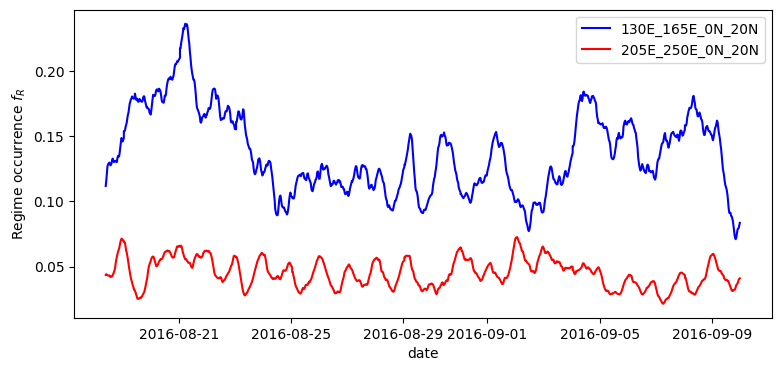

In [24]:
# Time variation of f_R

regions = '130E_165E_0N_20N','205E_250E_0N_20N'
maskid = 'TOOCAN'
cols = 'blue','red'
varid = 'Prec'

fig,ax = plt.subplots(figsize=(9,4))
    
for region,col in zip(regions,cols):
    
    # time
    time = dict_cs[region].time

    # fraction
    time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
    frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])

    ax.plot(time,frac_over_time,c=col,label=region)
    
# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)

ax.legend()
    
ax.set_xlabel('date')
ax.set_ylabel(r'Regime occurrence $f_R$')

plt.savefig(os.path.join(figdir,'fR_t_all_WP_EP.pdf'),bbox_inches='tight')

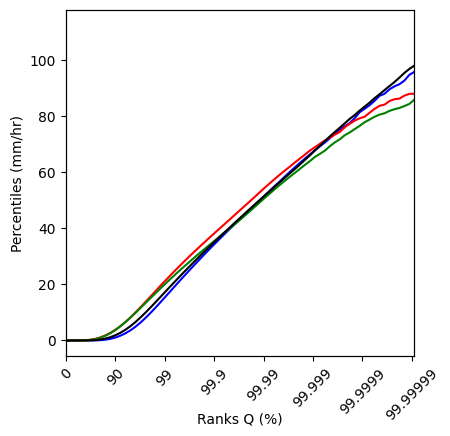

In [25]:
# Rain dsitribution over all regions

regions = '130E_165E_0N_20N','310E_340E_0N_20N','205E_250E_0N_20N','tropics'
maskid = 'TOOCAN'
cols = 'blue','red','green','k'
varid = 'pr'

dist_all = dict_cs[region].dist_pr_all
ranks = dist_all.ranks
rankmax = 99.99999

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

for region,col in zip(regions,cols):
    
    dist = getattr(dict_cs[region],'dist_%s_%s'%(varid,maskid))


    perc = dist.percentiles

    #- show data
    p1d.showData(ax,ranks,perc,c=col,rankmin=0, rankmax = rankmax)

    #- labels
    ax.set_xlabel('Ranks Q (%)',labelpad=40)
    ax.set_ylabel('Percentiles (mm/hr)')

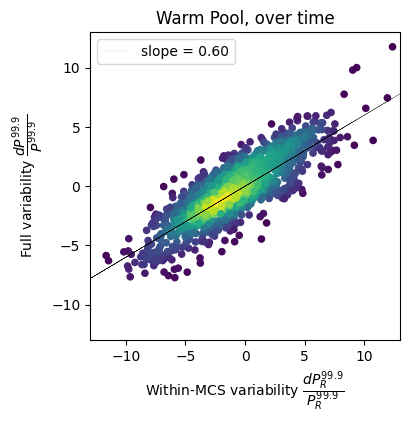

In [26]:
# Show variability of dPext vs dPext_R for regions with small fR variability

# region = 'tropics'
region = '130E_165E_0N_20N'
# region = '205E_250E_0N_20N'
# region = '310E_340E_0N_20N'

rank_e = 99.9

def getDelta(dist,dist_times,rank_e):
    
    # rank index
    i_e = dist.indexOfRank(rank_e)
    # full distrib percentile
    pr_e = dist.percentiles[i_e]
    # anomalies
    dpr_ext = np.array([d.percentiles[i_e] - pr_e for d in dist_times.values()])
    
    return dpr_ext

# x -- conditioned on TOOCAN

mask = 'TOOCAN'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
dist_times = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%mask)
x = getDelta(dist,dist_times,rank_e)

# y -- full

mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
dist_times = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%mask)
y = getDelta(dist,dist_times,rank_e)

# z -- density

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

#-- fit

# mask
keep = np.logical_and(np.logical_and(x<10,x>-10),np.logical_and(y<10,y>-10))
def func(x, a):
    return a * x
popt, pcov = curve_fit(func,x[keep],y[keep])


#-- show

fig,ax = plt.subplots(figsize=(4,4))
# points
ax.scatter(x,y,c=z,s=20)
# fit
ax.plot(x, func(x, *popt),'k',linestyle=':',linewidth=0.1,label='slope = %1.2f'%popt[0])
# legend
ax.legend()

ax.set_xlim((-13,13))
ax.set_ylim((-13,13))
# ax.set_title('Eastern Pacific ITCZ')
ax.set_xlabel(r'Within-MCS variability $\dfrac{dP_R^{%2.1f}}{P_R^{%2.1f}}$'%(rank_e,rank_e))
ax.set_ylabel(r'Full variability $\dfrac{dP^{%2.1f}}{P^{%2.1f}}$'%(rank_e,rank_e))
ax.set_title('Warm Pool, over time')

plt.savefig(os.path.join(figdir,'time_var_dP_dPR_%s.pdf'%region),bbox_inches='tight')

Calculate $f^{R|e}$ coefficient to compare:

$$f^{R|e} = \frac{f^{e|R}f_R}{f^e}$$

In [28]:
# f_R_e MIGHT BE WRONG THERE

# Same parameters as plot above
region = warm_pool
rank_e = 99.9

# f^{e|R} = percentile of rain of rank e within masked area R
mask = 'TOOCAN'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
i_e = dist.indexOfRank(rank_e)
f_e_R = dist.percentiles[i_e]/100
print(r'$f^{e|R}$ =',f_e_R)

# f_R
frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])
f_R = np.mean(frac_over_time)
print(r'$f_R$ =',f_R)

# f^e = percentile of rain of rank e within region
mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
i_e = dist.indexOfRank(rank_e)
f_e = dist.percentiles[i_e]/100
print(r'$f^e$ =',f_e)

# Resulting f^{R|e}
f_R_e = f_e_R*f_R/f_e
print(r'$f^{R|e}$ =',f_R_e)

$f^{e|R}$ = 0.34665183231234553
$f_R$ = 0.045160924045592556
$f^e$ = 0.233791412061546
$f^{R|e}$ = 0.06696189963214769


In [29]:
x,func(x,*popt)

(array([-0.34092591,  1.32751065,  4.60171212, ..., -0.49018622,
         1.37313137, -4.20788874]),
 array([-0.20452326,  0.79638067,  2.76059146, ..., -0.29406531,
         0.82374878, -2.52433473]))

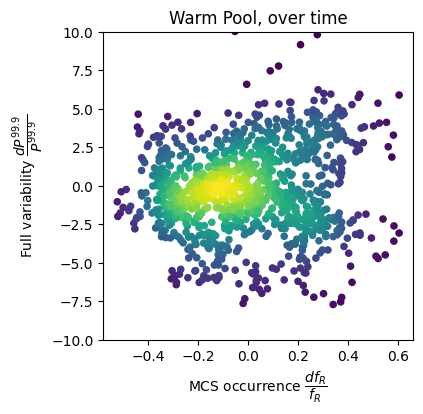

In [30]:
# Show variability of dPext vs df_R for regions with large fR variability

from scipy.stats import gaussian_kde

# region = 'tropics'
region = '130E_165E_0N_20N'
# region = '205E_250E_0N_20N'
# region = '310E_340E_0N_20N'

rank_e = 99.9

def getDelta(dist,dist_times,rank_e):
    
    # rank index
    i_e = dist.indexOfRank(rank_e)
    # full distrib percentile
    pr_e = dist.percentiles[i_e]
    # anomalies
    dpr_ext = np.array([d.percentiles[i_e] - pr_e for d in dist_times.values()])
    
    return dpr_ext


# x -- dfR/fR

frac_over_time = np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t])
frac_mean = np.mean(frac_over_time)
x = (frac_over_time - frac_mean)/frac_mean

# y -- full dP/P

mask = 'all'
dist = getattr(dict_cs[region],'dist_pr_%s'%mask)
dist_times = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%mask)
y = getDelta(dist,dist_times,rank_e)


# z -- density

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fit



#-- show
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,c=z,s=20)
# ax.set_xlim((-8,8))
ax.set_ylim((-10,10))
# ax.set_title('Eastern Pacific ITCZ')
ax.set_ylabel(r'Full variability $\dfrac{dP^{%2.1f}}{P^{%2.1f}}$'%(rank_e,rank_e))
ax.set_xlabel(r'MCS occurrence $\dfrac{df_R}{f_R}$')
ax.set_title('Warm Pool, over time')

plt.savefig(os.path.join(figdir,'time_var_dP_dfR_%s.pdf'%region),bbox_inches='tight')

In [ ]:
# Show variability of dPext vs dPext_R and df_R in 3D plot.



In [11]:
# Calculate frequencies



In [31]:
# Calculate distribution slopes



In [31]:
# Compute all alpha

regions = warm_pool, eastern_pacific, atlantic, 'tropics'
maskids = 'all', 'TOOCAN'

# initialize
fit_dist = dict()

for region in regions:
    
    fit_dist[region] = {}
    
    for maskid in maskids:
        
        print('region : %s, mask: %s'%(region,mask))
        
        fit_dist[region][maskid] = {}
        
        dist = getattr(dict_cs[region],'dist_pr_%s'%maskid)
        ranks = dist.ranks
        perc = dist.percentiles

        # -- fit of distributions
        s_fit = slice(30,70)
        x = np.log10(1-ranks/100)
        y = perc

        # mask
        def func(x,a,b):
            return a * x + b
        popt, pcov = curve_fit(func,x[s_fit],y[s_fit])
        alpha,beta = popt[0],popt[1]
        
        # store
        fit_dist[region][maskid]['alpha'] = alpha
        fit_dist[region][maskid]['beta'] = beta
        
        print('  slope alpha, all:',alpha)
        print('  slope beta, all:',beta)
        

region : 130E_165E_0N_20N, mask: all
  slope alpha, all: -15.600796644985476
  slope beta, all: -22.026334079441092
region : 130E_165E_0N_20N, mask: all
  slope alpha, all: -15.390332027386451
  slope beta, all: -9.956708898519192
region : 205E_250E_0N_20N, mask: all
  slope alpha, all: -14.149966208162725
  slope beta, all: -23.65943181960636
region : 205E_250E_0N_20N, mask: all
  slope alpha, all: -12.993330015035797
  slope beta, all: -1.1417689391997645
region : 310E_340E_0N_20N, mask: all
  slope alpha, all: -14.752142556959885
  slope beta, all: -21.91355322651728
region : 310E_340E_0N_20N, mask: all
  slope alpha, all: -12.922700982967676
  slope beta, all: 2.495568507897223
region : tropics, mask: all
  slope alpha, all: -15.66121321405891
  slope beta, all: -30.83878835335923
region : tropics, mask: all
  slope alpha, all: -15.80222238525759
  slope beta, all: -11.447838865838698


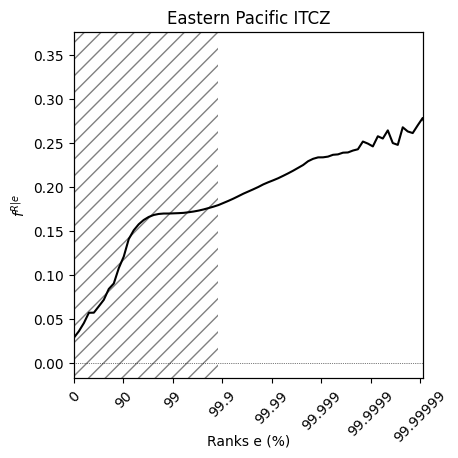

In [40]:
# show f_R_e vs percentile rank

# Same parameters as plot above
region = eastern_pacific
Npts = 70
# s_ranks = slice(0,Npts)
s_ranks = slice(None)

# Full
dist_all = dict_cs[warm_pool].dist_pr_all
# in Region
dist_R = getattr(dict_cs[warm_pool],'dist_pr_%s'%maskid)

# ranks
dist_all = dict_cs[warm_pool].dist_pr_all
ranks = dist_all.ranks[s_ranks]
# ranks = dist_all.ranks
rankmax = 99.99999

###-- CAREFUL, need to implement f_R_e it with interpolation like on the first distribution figure, 
### otherwise calculation is wrong

#~ P(f^e)
perc_all = dist_all.percentiles
perc_all[perc_all < 0] = 0
f_e = 1-ranks/100

#~ P(f^{e|R})
perc_R = dist_R.percentiles
perc_R[perc_R < 0] = 0

#~ fraction of rain percentile within weather regime expressed as f_R_e*perc_all

f_interp = si.interp1d(perc_R,1-ranks/100)
f_e_R = f_interp(perc_all)
# get f_R
time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
f_R = np.mean(np.array([time_dist[i_t].frac for i_t in dict_cs[eastern_pacific].range_t]))
# compute ranks(f_R_e)
f_R_e = f_e_R*f_R/f_e
      
#-- show

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
ax.axhline(y=0,linestyle=':',c='k',linewidth=0.5)
p1d.showData(ax,ranks[s_ranks],f_R_e,c='k',rankmin=0, rankmax = rankmax)
# p1d.showData(ax,ranks,dP_P_TOOCAN,c='grey',rankmin=0, rankmax = rankmax)
# p1d.showData(ax,ranks,dfR_fR,c='r',rankmin=0, rankmax = rankmax)
p1d.addXHatch(ax,ranks,[0,29])

# ax.set_ylim((-0.05,0.2))

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel(r'$f^{R|e}$')
ax.set_title(r'Eastern Pacific ITCZ')

plt.show()

(70,) (70,)


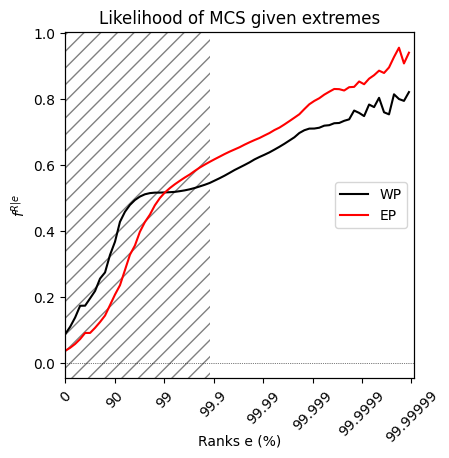

In [41]:
def compute_f_R_e(region):
    
    Npts = 70
    s_ranks = slice(0,Npts)
    
    # Full
    dist_all = dict_cs[region].dist_pr_all
    # in Region
    dist_R = getattr(dict_cs[region],'dist_pr_%s'%maskid)

    # ranks
    dist_all = dict_cs[region].dist_pr_all
    ranks = dist_all.ranks[s_ranks]
    
    #~ P(f^e)
    perc_all = dist_all.percentiles[s_ranks]
    perc_all[perc_all < 0] = 0
    f_e = 1-ranks/100

    #~ P(f^{e|R})
    perc_R = dist_R.percentiles[s_ranks]
    perc_R[perc_R < 0] = 0

    #~ fraction of rain percentile within weather regime expressed as f_R_e*perc_all

    f_interp = si.interp1d(perc_R,1-ranks/100)
    f_e_R = f_interp(perc_all)
    # get f_R
    time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
    f_R = np.mean(np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t]))
    # compute ranks(f_R_e)
    f_R_e = f_e_R*f_R/f_e
    
    return f_R_e

Npts = 70
s_ranks = slice(0,Npts)

f_WP_e = compute_f_R_e(warm_pool)
f_EP_e = compute_f_R_e(eastern_pacific)

#-- show

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
ax.axhline(y=0,linestyle=':',c='k',linewidth=0.5)
print(ranks[s_ranks].shape,f_WP_e.shape)
p1d.showData(ax,ranks[s_ranks],f_WP_e,c='k',rankmin=0, rankmax = rankmax,label='WP')
p1d.showData(ax,ranks[s_ranks],f_EP_e,c='r',rankmin=0, rankmax = rankmax,label='EP')

p1d.addXHatch(ax,ranks,[0,29])

# ax.set_ylim((-0.05,0.2))

ax.legend()

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel(r'$f^{R|e}$')
ax.set_title(r'Likelihood of MCS given extremes')

plt.show()

/tmp/ipykernel_2109786/3085994685.py:21: RuntimeWarning: divide by zero encountered in true_divide
  dP_P = (perc_WP-perc_EP)/perc_EP*100
/tmp/ipykernel_2109786/3085994685.py:21: RuntimeWarning: invalid value encountered in true_divide
  dP_P = (perc_WP-perc_EP)/perc_EP*100
/tmp/ipykernel_2109786/3085994685.py:56: RuntimeWarning: divide by zero encountered in true_divide
  C2 = f_R_e[s_ranks] * alpha * dfR_fR / perc_EP_all
/home/bfildier/analyses/explore-multiscale-extremes/modules/plot1D.py:191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Polygon([[x[i_xlim[0]], ax.get_ylim()[0]],\


alpha = 12.993330015035797
dfR_fR = [203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333]


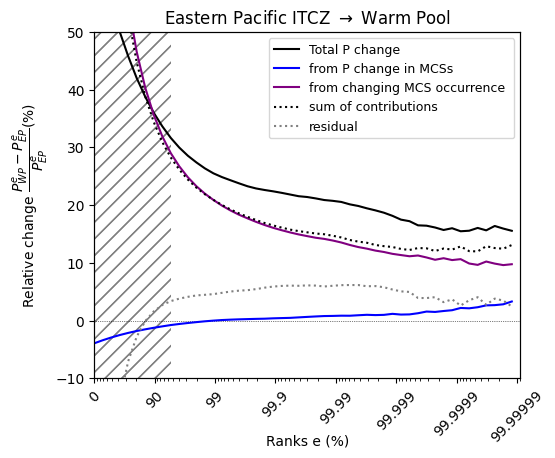

In [44]:
# Change in percentile from Warm Pool to Eastern Pacific


# ranks
dist_all = dict_cs[warm_pool].dist_pr_all
Npts = 70
s_ranks = slice(0,Npts)
ranks = dist_all.ranks[s_ranks]
# ranks = dist_all.ranks
rankmax = 99.99999
rankmin = 99


def getPrChange(mask):

    # distributions
    perc_WP = getattr(dict_cs[warm_pool],'dist_pr_%s'%mask).percentiles[s_ranks]
    perc_EP = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%mask).percentiles[s_ranks]

    # relative change 
    dP_P = (perc_WP-perc_EP)/perc_EP*100
    
    # replace first decade with nans
    dP_P[:10] = np.nan
    
    return dP_P

# 1. dP/P

dP_P_all = getPrChange('all')

# 2. dP_R/P_R

dP_P_TOOCAN = getPrChange('TOOCAN')

# 3. dfR/fR
time_dist_WP = getattr(dict_cs[warm_pool],'dict_dist_pr_%s_sliced'%maskid)
frac_over_time_WP = np.array([time_dist_WP[i_t].frac for i_t in dict_cs[warm_pool].range_t])
f_WP = np.mean(frac_over_time_WP)

time_dist_EP = getattr(dict_cs[eastern_pacific],'dict_dist_pr_%s_sliced'%maskid)
frac_over_time_EP = np.array([time_dist_EP[i_t].frac for i_t in dict_cs[eastern_pacific].range_t])
f_EP = np.mean(frac_over_time_EP)

dfR_fR = np.full(Npts,(f_WP - f_EP)/f_EP*100)

##-- Component 1
C1 = f_R_e[s_ranks] * dP_P_TOOCAN

##-- Component 2
alpha = -fit_dist[eastern_pacific]['TOOCAN']['alpha']
perc_EP_all = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%'all').percentiles[s_ranks]
perc_EP_TOOCAN = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%'TOOCAN').percentiles[s_ranks]
print('alpha =',alpha)
print('dfR_fR =',dfR_fR)
C2 = f_R_e[s_ranks] * alpha * dfR_fR / perc_EP_all
# C2 = alpha * dfR_fR / perc_EP_all

##-- Sum
C_total = C1 + C2

##-- Residual
C_residual = dP_P_all - C_total

#-- show

fig,ax = plt.subplots(ncols=1,figsize=(5.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
ax.axhline(y=0,linestyle=':',c='k',linewidth=0.5)

# 3 full components
p1d.showData(ax,ranks,dP_P_all,c='k',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='Total P change')
p1d.showData(ax,ranks,C1,c='b',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='from P change in MCSs')
p1d.showData(ax,ranks,C2,c='purple',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='from changing MCS occurrence ')
p1d.showData(ax,ranks,C_total,c='k',linestyle=':',rankmin=rankmin, rankmax = rankmax,label='sum of contributions')
p1d.showData(ax,ranks,C_residual,c='grey',linestyle=':',rankmin=rankmin, rankmax = rankmax,label='residual')


# 2 intermediate components
# p1d.showData(ax,ranks,dP_P_TOOCAN,c='grey',linestyle=':',rankmin=0, rankmax = rankmax)
# p1d.showData(ax,ranks,dfR_fR,c='r',linestyle=':',rankmin=0, rankmax = rankmax)
p1d.addXHatch(ax,ranks,[0,29],facecolor='w')
# p1d.addXHatch(ax,ranks,[0,29],color='lightgray')
p1d.addXHatch(ax,ranks,[0,29])

ax.set_ylim((-10,50))

ax.legend(fontsize=9)
#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel(r'Relative change $\dfrac{P^e_{WP}-P^e_{EP}}{P^e_{EP}}$(%)')
ax.set_title(r'Eastern Pacific ITCZ $\rightarrow$ Warm Pool')

plt.savefig(os.path.join(figdir,'dP_P_EP_WP_all_contribs.pdf'),bbox_inches='tight')

plt.show()

/tmp/ipykernel_2109786/3277584984.py:21: RuntimeWarning: divide by zero encountered in true_divide
  dP_P = (perc_WP-perc_EP)/perc_EP*100
/tmp/ipykernel_2109786/3277584984.py:21: RuntimeWarning: invalid value encountered in true_divide
  dP_P = (perc_WP-perc_EP)/perc_EP*100
/tmp/ipykernel_2109786/3277584984.py:58: RuntimeWarning: divide by zero encountered in true_divide
  C2 = alpha * dfR_fR / perc_EP_all
/tmp/ipykernel_2109786/3277584984.py:69: RuntimeWarning: divide by zero encountered in true_divide
  C3 = -alpha / perc_EP_all * dfRe_fRe #* f_e
/home/bfildier/analyses/explore-multiscale-extremes/modules/plot1D.py:191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Polygon([[x[i_xlim[0]], ax.get_ylim()[0]],\


alpha = 12.993330015035797
dfR_fR = [203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333
 203.38341333 203.38341333 203.38341333 203.38341333 203.38341333]


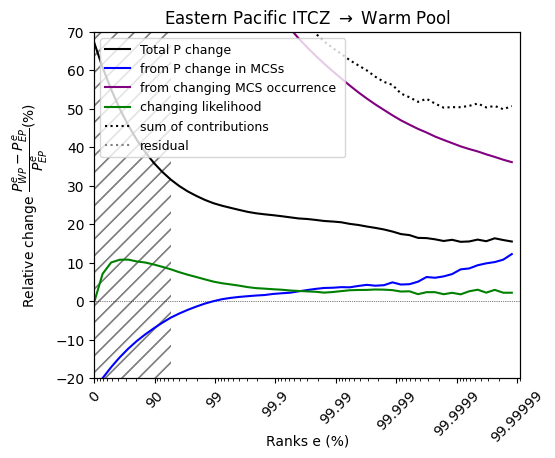

In [46]:
# 3 terms


# ranks
dist_all = dict_cs[warm_pool].dist_pr_all
Npts = 70
s_ranks = slice(0,Npts)
ranks = dist_all.ranks[s_ranks]
# ranks = dist_all.ranks
rankmax = 99.99999
rankmin = 99


def getPrChange(mask):

    # distributions
    perc_WP = getattr(dict_cs[warm_pool],'dist_pr_%s'%mask).percentiles[s_ranks]
    perc_EP = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%mask).percentiles[s_ranks]

    # relative change 
    dP_P = (perc_WP-perc_EP)/perc_EP*100
    
    # replace first decade with nans
    dP_P[:10] = np.nan
    
    return dP_P

# 1. dP/P

dP_P_all = getPrChange('all')

# 2. dP_R/P_R

dP_P_TOOCAN = getPrChange('TOOCAN')

# 3. dfR/fR
time_dist_WP = getattr(dict_cs[warm_pool],'dict_dist_pr_%s_sliced'%maskid)
frac_over_time_WP = np.array([time_dist_WP[i_t].frac for i_t in dict_cs[warm_pool].range_t])
f_WP = np.mean(frac_over_time_WP)

time_dist_EP = getattr(dict_cs[eastern_pacific],'dict_dist_pr_%s_sliced'%maskid)
frac_over_time_EP = np.array([time_dist_EP[i_t].frac for i_t in dict_cs[eastern_pacific].range_t])
f_EP = np.mean(frac_over_time_EP)

dfR_fR = np.full(Npts,(f_WP - f_EP)/f_EP*100)

##-- Component 1
# C1 = f_R_e[s_ranks] * dP_P_TOOCAN
C1 = dP_P_TOOCAN

##-- Component 2
alpha = -fit_dist[eastern_pacific]['TOOCAN']['alpha']
perc_EP_all = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%'all').percentiles[s_ranks]
perc_EP_TOOCAN = getattr(dict_cs[eastern_pacific],'dist_pr_%s'%'TOOCAN').percentiles[s_ranks]
print('alpha =',alpha)
print('dfR_fR =',dfR_fR)
# C2 = f_R_e[s_ranks] * alpha * dfR_fR / perc_EP_all
C2 = alpha * dfR_fR / perc_EP_all


##-- Component 3
f_WP_e = compute_f_R_e(warm_pool)
f_EP_e = compute_f_R_e(eastern_pacific)
dfRe_fRe = np.full(Npts,(f_WP_e - f_EP_e)/f_EP_e*100)

# f_e
f_e = 1-ranks/100

C3 = -alpha / perc_EP_all * dfRe_fRe #* f_e

##-- Sum
C_total = C1 + C2 + C3

##-- Residual
C_residual = dP_P_all - C_total

#-- show

fig,ax = plt.subplots(ncols=1,figsize=(5.5,4.5))

#- set frame
p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

#- show data
ax.axhline(y=0,linestyle=':',c='k',linewidth=0.5)

# 3 full components
p1d.showData(ax,ranks,dP_P_all,c='k',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='Total P change')
p1d.showData(ax,ranks,C1,c='b',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='from P change in MCSs')
p1d.showData(ax,ranks,C2,c='purple',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='from changing MCS occurrence ')
p1d.showData(ax,ranks,C3,c='green',linestyle='-',rankmin=rankmin, rankmax = rankmax,label='changing likelihood')
p1d.showData(ax,ranks,C_total,c='k',linestyle=':',rankmin=rankmin, rankmax = rankmax,label='sum of contributions')
p1d.showData(ax,ranks,C_residual,c='grey',linestyle=':',rankmin=rankmin, rankmax = rankmax,label='residual')


# 2 intermediate components
# p1d.showData(ax,ranks,dP_P_TOOCAN,c='grey',linestyle=':',rankmin=0, rankmax = rankmax)
# p1d.showData(ax,ranks,dfR_fR,c='r',linestyle=':',rankmin=0, rankmax = rankmax)
p1d.addXHatch(ax,ranks,[0,29],facecolor='w')
# p1d.addXHatch(ax,ranks,[0,29],color='lightgray')
p1d.addXHatch(ax,ranks,[0,29])

ax.set_ylim((-20,70))

ax.legend(fontsize=9)
#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel(r'Relative change $\dfrac{P^e_{WP}-P^e_{EP}}{P^e_{EP}}$(%)')
ax.set_title(r'Eastern Pacific ITCZ $\rightarrow$ Warm Pool')

plt.savefig(os.path.join(figdir,'dP_P_EP_WP_all_contribs_2.pdf'),bbox_inches='tight')

plt.show()

In [58]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')



array([-7.35160240e-02, -9.91891627e-03, -1.34745846e-04, -1.34745846e-04,
        4.75733937e-03,  9.64942458e-03,  1.45415098e-02,  1.94335950e-02,
        2.92177659e-02,  3.41098511e-02,  4.38940211e-02,  5.36781915e-02,
        1.02599042e-01,  2.20009090e-01,  4.30368764e-01,  7.67922635e-01,
        1.26691533e+00,  1.95669938e+00,  2.85195100e+00,  3.96734647e+00,
        5.28820933e+00,  6.79497183e+00,  8.45338838e+00,  1.02194308e+01,
        1.20686394e+01,  1.39569852e+01,  1.58600053e+01,  1.77581345e+01,
        1.96562642e+01,  2.15299328e+01,  2.33791412e+01,  2.52087792e+01,
        2.70139607e+01,  2.87848943e+01,  3.05362615e+01,  3.22778427e+01,
        3.39851808e+01,  3.56680575e+01,  3.73313648e+01,  3.89897832e+01,
        4.06271368e+01,  4.22455506e+01,  4.38396906e+01,  4.54338278e+01,
        4.70198760e+01,  4.86140160e+01,  5.01879226e+01,  5.17456520e+01,
        5.33721573e+01,  5.50108022e+01])

In [54]:
dict_cs[warm_pool].dist_pr_all

< DistributionChunked object:
 . bintype: invlogQ
 . nbins: 81
 . nbpd: 10
 . nppb: 4
 . nd: 8
 . fill_last_decade: False
 . name: pr, all, DYAMOND-SAM 130E_165E_0N_20N, all times
 . size: 493832192
 . vmin: -0.07596207
 . vmax: 106.2903
 . rank_edges: <class 'numpy.ndarray'>
 . ranks: <class 'numpy.ndarray'>
 . percentiles: <class 'numpy.ndarray'>
 . bins: <class 'numpy.ndarray'>
 . density: None
 . bin_locations_stored: [False False False ... False False False]
 . overwrite: False
 . dist_chunks: <class 'list'>
 . chunks_to_ignore: <class 'list'>
 . nchunks: 1086
 . size_chunks: <class 'list'>
 . vmin_chunks: <class 'list'>
 . vmax_chunks: <class 'list'>
 . bin_locations: {}
 >

# DEBUG

# Rain distributions & MCS contribution

f_R_e(P99.9) =  0.5482838997542888
slope alpha, all: -15.66121321405891
slope alpha, R: -15.80222238525759
slope beta, all: -30.83878835335923
slope beta, R: -11.447838865838698
f_R_e(P99.9) =  0.5518218978941911
slope alpha, all: -15.600796644985476
slope alpha, R: -15.390332027386451
slope beta, all: -22.026334079441092
slope beta, R: -9.956708898519192


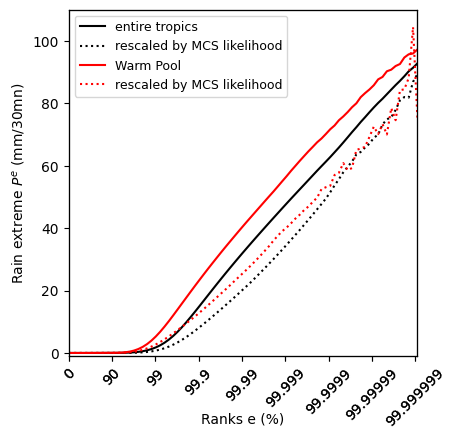

In [37]:
#### RECODE BELOW FOR TROPICS + WARM POOL

# Show distributions

# region = warm_pool
regions2show = 'tropics', warm_pool
colors = 'k','r'
names = 'entire tropics', 'Warm Pool'

maskid = 'TOOCAN'

#-- init figure

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

ranks = dist_all.ranks
rankmax = 99.999999

prec_all_regions = []
prec_R_regions = []
prec_R_e_regions = []

for region,color,name in zip(regions2show,colors,names):

    # Full
    dist_all = dict_cs[region].dist_pr_all
    # in Region
    # dist_R = dict_cs[region].dist_pr_PW_40
    dist_R = getattr(dict_cs[region],'dist_pr_%s'%maskid)

    #- distributions

    #~ P(f^e)
    perc_all = dist_all.percentiles
    perc_all[perc_all < 0] = 0
    f_e = 1-ranks/100

    #~ P(f^{e|R})
    perc_R = dist_R.percentiles
    perc_R[perc_R < 0] = 0

    #~ fraction of rain percentile within weather regime expressed as f_R_e*perc_all
    # interpolate f^{e|R} onto P
    # f_interp = si.interp1d(np.hstack([0,perc_R]),np.hstack([0,ranks]),'spline')
    # ranks_e_R = f_interp(perc_all)
    # f_e_R = 1-ranks_e_R/100

    f_interp = si.interp1d(perc_R,1-ranks/100)
    f_e_R = f_interp(perc_all)
    # get f_R
    time_dist = getattr(dict_cs[region],'dict_dist_pr_%s_sliced'%maskid)
    f_R = np.mean(np.array([time_dist[i_t].frac for i_t in dict_cs[region].range_t]))
    # compute ranks(f_R_e)
    f_R_e = f_e_R*f_R/f_e
    perc_R_e = f_R_e*perc_all
    # print value at rank
    rank_e = 99.9
    i_e = dist_all.indexOfRank(rank_e)
    print('f_R_e(P99.9) = ',f_R_e[i_e])

    # -- fit of distributions
    s_fit = slice(30,70)
    x = np.log10(1-ranks/100)
    y_all = perc_all
    y_R = perc_R

    # mask
    def func(x,a,b):
        return a * x + b
    popt_all, pcov = curve_fit(func,x[s_fit],y_all[s_fit])
    popt_R, pcov = curve_fit(func,x[s_fit],y_R[s_fit])
    alpha_all,beta_all = popt_all[0],popt_all[1]
    alpha_WP,beta_WP = popt_R[0],popt_R[1]
    print('slope alpha, all:',popt_all[0])
    print('slope alpha, R:',popt_R[0])
    print('slope beta, all:',popt_all[1])
    print('slope beta, R:',popt_R[1])

    #- set frame
    p1d.setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

    #- show data
    
    # full distribution
    p1d.showData(ax,ranks,perc_all, c=color,rankmin=0, rankmax = rankmax, label = '%s'%name)
    # distribution within MCSs
    # p1d.showData(ax,ranks,perc_R, c='b',rankmin=0, rankmax = rankmax)
    # full distribution rescaled by the MCS likelihood
    p1d.showData(ax,ranks,perc_R_e, c=color,linestyle=':',rankmin=0, rankmax = rankmax, label = 'rescaled by MCS likelihood')

# #- show linear fits
# p1d.showData(ax,ranks,func(x,*popt_all), c='k',linestyle='--',linewidth=1,rankmin=0, rankmax = rankmax,label=r'slope $\alpha$ = %2.1f'%popt_all[0])
# p1d.showData(ax,ranks,func(x,*popt_R), c='b',linestyle='--',linewidth=1,rankmin=0, rankmax = rankmax,label=r'slope $\alpha_R$ = %2.1f'%popt_R[0])

# legend
ax.legend(loc='upper left',fontsize=9)

#- labels
ax.set_xlabel('Ranks e (%)',labelpad=40)
ax.set_ylabel('Rain extreme $P^e$ (mm/30mn)')

ax.set_ylim((-1,110))

plt.savefig(os.path.join(figdir,'dist_P_PR_%s_%s.pdf'%regions2show),bbox_inches='tight')

In [37]:
dist_pr_tropics = dict_cs['tropics'].dist_pr_all
perc = dist_pr_tropics.percentiles
ranks = dist_pr_tropics.ranks

rank_target = 99.99
i_target = np.where(ranks == rank_target)[0][0]
perc_target = perc[i_target]
print(perc_target)

32.19467629011342
